In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sys import stdout
#import mysql.connector as mariadb
import pymysql as mariadb


In [2]:
import gmres_display

In [3]:
def database_generator(cursor, data, n = None, show_progress = True):

    cursor.execute("SELECT COUNT(*) from Experiment")
    if not n:
        n_rows = cursor.fetchone()[0]
    else:
        n_rows = n
    c_rows = 0
    
    request = "SELECT"
    first = True
    for key in data:
        if not first:
            request += ","
        else:
            first = False
        request += " "
        if key == "faults":
            request += "fault_i, fault_k, fault_f, fault_bit, fault_reg"
        else:
            request += key
    request += " FROM Experiment"
    
    first = True
    for key in data:
        if data[key]:
            if first:
                first = False
                request += " WHERE "
            else:
                request += " AND "
            request += key + " = " + str(data[key])
        
    
    print request    
    cursor.execute(request)
    row = cursor.fetchone()
    while row is not None:
        c_row = {}
        k = 0
        for key in data:
            if key == "faults":
                fault = {}
                fault["loc"] = {"i":row[k], "j":0, "k":row[k+1]}
                fault["timer"] = row[k+2]
                fault["bit"] = row[k+3]
                fault["register"] = row[k+4]
                c_row["faults"] = [fault] #TODO
                k += 4
            elif key == "l" or key == "m":
                c_row[key] = int(row[k])
            elif key == "residuals" or key == "true_residuals":
                c_row[key] = np.fromstring(row[k])
            else:
                c_row[key] = row[k]
            k += 1
        c_rows += 1
        if show_progress:
            new_progress = (100 * c_rows) / n_rows
            stdout.write("\r%d %c " % (new_progress, '%'))
            stdout.flush()
        yield c_row
        if (c_rows == n):
            break
        row = cursor.fetchone()
    

In [4]:
mariadb_connection = mariadb.connect(user='resilience', 
                                     #password='resilience_password', 
                                     passwd='resilience_password',
                                     #host='192.168.1.48',
                                     database='gmres')
cursor = mariadb_connection.cursor()

SELECT A, residual, true_residual, fault_i, fault_k, fault_f, fault_bit, fault_reg, residuals, true_residuals, l FROM Experiment WHERE A = 'Brethour/coater1'
10 % Brethour/coater1
[{'loc': {'i': 83, 'k': 69, 'j': 0}, 'bit': 53, 'register': 2, 'timer': 583}]


ValueError: Can only output finite numbers in PDF

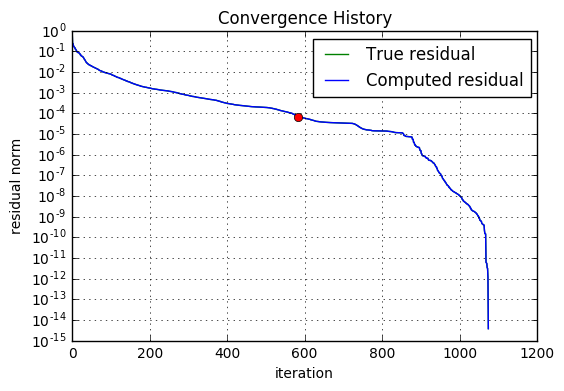

20 % Brethour/coater1
[{'loc': {'i': 197, 'k': 34, 'j': 0}, 'bit': 4, 'register': 1, 'timer': 207}]


ValueError: Can only output finite numbers in PDF

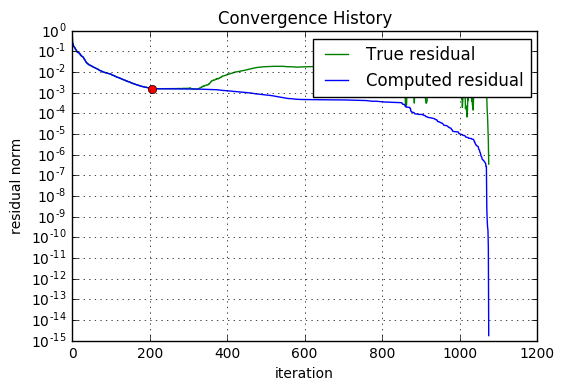

30 % Brethour/coater1
[{'loc': {'i': 199, 'k': 431, 'j': 0}, 'bit': 54, 'register': 3, 'timer': 170}]


ValueError: Can only output finite numbers in PDF

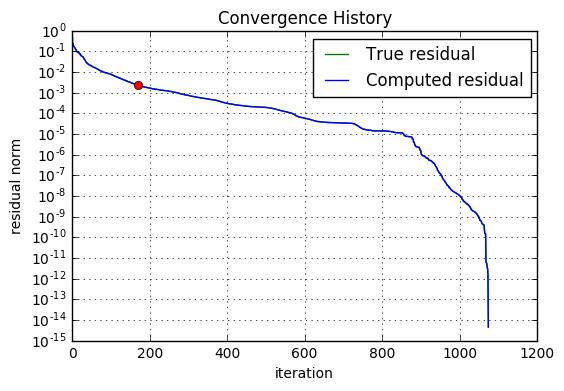

40 % Brethour/coater1
[{'loc': {'i': 199, 'k': 439, 'j': 0}, 'bit': 19, 'register': 2, 'timer': 209}]


ValueError: Can only output finite numbers in PDF

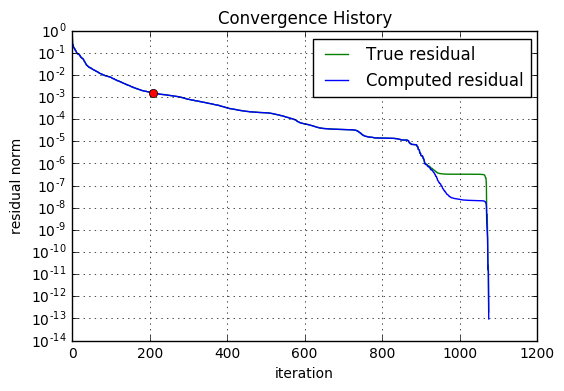

50 % Brethour/coater1
[{'loc': {'i': 220, 'k': 247, 'j': 0}, 'bit': 39, 'register': 2, 'timer': 41}]


ValueError: Can only output finite numbers in PDF

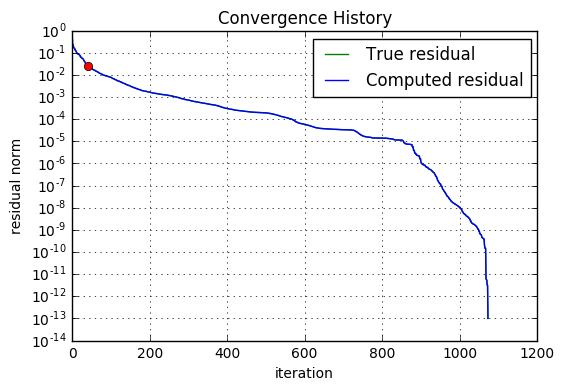

60 % Brethour/coater1
[{'loc': {'i': 230, 'k': 206, 'j': 0}, 'bit': 46, 'register': 2, 'timer': 1029}]


ValueError: Can only output finite numbers in PDF

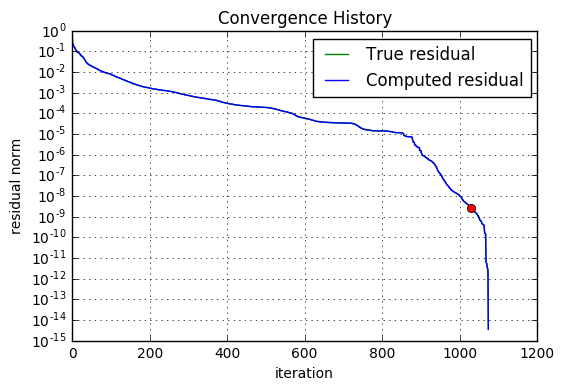

70 % Brethour/coater1
[{'loc': {'i': 271, 'k': 286, 'j': 0}, 'bit': 37, 'register': 1, 'timer': 488}]


ValueError: Can only output finite numbers in PDF

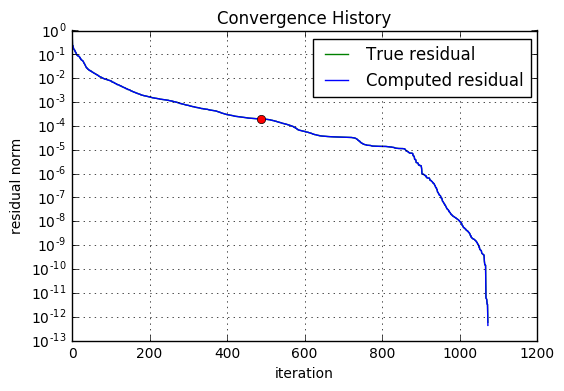

80 % Brethour/coater1
[{'loc': {'i': 282, 'k': 368, 'j': 0}, 'bit': 11, 'register': 3, 'timer': 996}]


ValueError: Can only output finite numbers in PDF

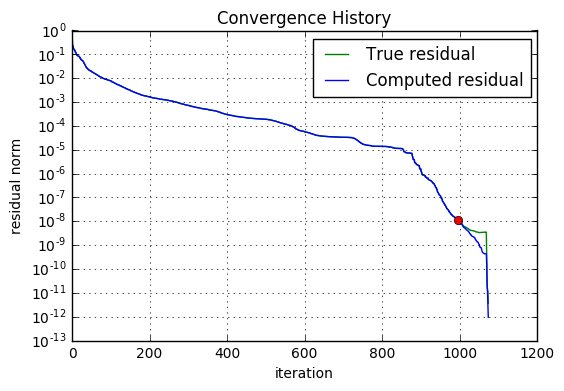

90 % Brethour/coater1
[{'loc': {'i': 452, 'k': 585, 'j': 0}, 'bit': 18, 'register': 1, 'timer': 850}]


ValueError: Can only output finite numbers in PDF

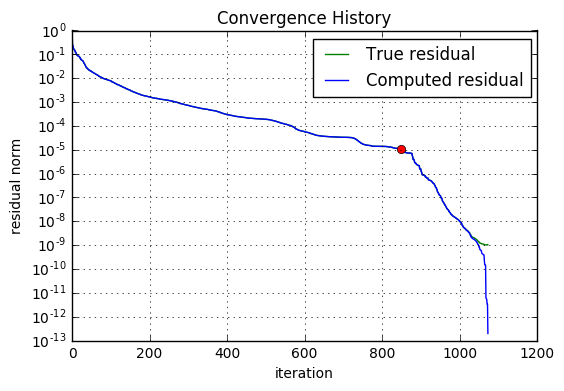

100 % Brethour/coater1
[{'loc': {'i': 466, 'k': 180, 'j': 0}, 'bit': 50, 'register': 2, 'timer': 576}]


ValueError: Can only output finite numbers in PDF

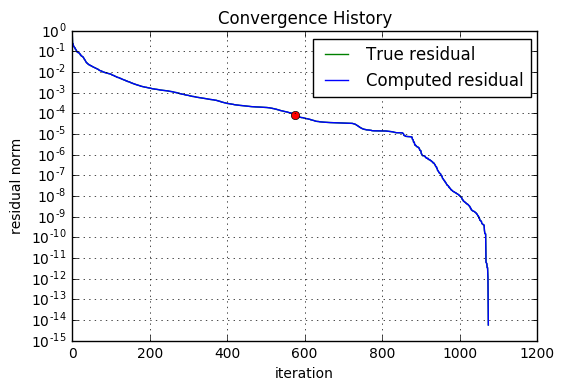

In [5]:
for d in database_generator(cursor, {"A":"'Brethour/coater1'", "residual":None, "residuals":None, "true_residual":None, "true_residuals": None, "faults":None, "l":None}, 10):
    print d["A"]
    print d["faults"]
    gmres_display.convergence_history(d, true_residual = True, fault = True)
    plt.show()

In [6]:
mariadb_connection.close()